# I. Set Up

In [1]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import umap
import seaborn as sns
import fnmatch
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

2023-04-23 22:36:28.347696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dropdown(description='Set :', options=('Full', 'All', 'New', 'Bona'), value='Full')

# II. Load Data

In [3]:
# Set ID
set_id = set_widget.value
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist*nE16*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='Histogram File :',disabled=False); input_widget



Dropdown(description='Histogram File :', options=('hist2D-Full-nE16-nt24-normZ.pkl', 'hist2D-Full-nE16-nt24-no…

In [4]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

Number of Features:  95473
Number of Property Sets:  95473


# III. CLUSTERING

In [7]:
files = os.listdir(f'{global_path}/{set_id}/')
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*hist2D*nE16*PCA*rs11.csv')]
tsne_widget = widgets.Dropdown(options=tsne_files[:],value=tsne_files[0],description='TSNE File :',disabled=False); tsne_widget

Dropdown(description='TSNE File :', options=('tsne-Full-hist2D-Full-nE16-nt24-normnone-2D-perp75-lr100-ee1-it3…

In [8]:
import hdbscan 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Load 
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')
# Filter on variability
df_properties_filter = df_properties#.loc[df_properties["var_prob_m"] >= 0.8]
filter_ids = df_properties_filter["obsreg_id"]
df_tsne_filter = df_tsne[df_tsne["obsreg_id"].isin(filter_ids)]
tsne12 = df_tsne_filter[['tsne1', 'tsne2']].values

In [9]:
# Run DBSCAN
eps = 1.5
ms = 25
dbscan=DBSCAN(eps=eps,min_samples = ms)
clusters=dbscan.fit(tsne12)
labels=clusters.labels_
n_clusters = len(set(labels))- (1 if -1 in labels else 0)
df_tsne_filter['cluster'] = labels

# Save TSNE Output
df_tsne_filter.to_csv(f'{global_path}/{set_id}/DBSCANres-{set_id}-{tsne_file}-EPS{eps}-MS{ms}.csv', index=False)

#Display Performance
silhouette_avg = silhouette_score(tsne12, labels)
ch_score = calinski_harabasz_score(tsne12, labels)
db_score = davies_bouldin_score(tsne12, labels)
print("Calinski-Harabasz Index: ", ch_score)
print("Davies-Bouldin Index: ", db_score)
print("Silhouette score:", silhouette_avg)
print("Number of Clusters:", n_clusters)


Calinski-Harabasz Index:  2564.1458130260003
Davies-Bouldin Index:  1.6057364255222262
Silhouette score: -0.30878206632597577
Number of Clusters: 33


SHOW

In [12]:
# Load DBSCAN RESULT
files = os.listdir(f'{global_path}/{set_id}/')
dbscan_files = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*csv')]
dbscan_widget = widgets.Dropdown(options=dbscan_files[:],value=dbscan_files[0],description='TSNE File :',disabled=False); dbscan_widget

Dropdown(description='TSNE File :', options=('DBSCANres-Full-tsne-Full-hist3D-Full-nE16-nt24-ndt16-normnone-2D…

In [13]:
# Load the DataFrame from the CSV file
dbscan_file = dbscan_widget.value
df_tsne_filter = pd.read_csv(f'{global_path}/{set_id}/{dbscan_file}')

#####SELECTED ANOMALIES
dip_in_blip = ['14431_16']
dips_select = ['10783_10','10871_10','11059_10','9070_10','9072_10','11272_13','10783_10','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86','11988_38','13814_586','13812_586','13828_596','13828_46']
dips_maybe = ['12992_101','12995_101','13814_586','13813_218','13814_237','13828_596']
flares_select = ['10542_331','4395_992','2227_220','16444_1025','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','9109_333','9109_344','13637_1078','14368_489','1042_24','11016_168','11737_157','12390_136']
flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
rosanne = ['13814_567']
lin = ['4062_31', '13454_56']
irwin = ['3926_13','7800_4','7799_16','8490_30']

tsne_flares = df_tsne_filter.loc[df_tsne['obsreg_id'].isin(flares_select)]
tsne_dips = df_tsne_filter.loc[df_tsne['obsreg_id'].isin(dips_select)]
tsne_rosanne = df_tsne_filter.loc[df_tsne['obsreg_id'].isin(rosanne)]
tsne_lin_irwin = df_tsne_filter.loc[df_tsne['obsreg_id'].isin(lin + irwin)]

anomalies = pd.concat([tsne_flares, tsne_dips, tsne_rosanne, tsne_lin_irwin])
anomalies.head(50)

,tsne1,tsne2,obsreg_id,cluster
1075,32.817090,-26.395410,1042_24,0
2747,-68.966440,44.077724,10822_185,14
3806,-16.800571,-92.396670,11016_168,11
6204,-72.940636,41.560837,11737_157,14
9587,14.326198,89.513900,12390_136,1
14918,-85.373970,-12.729993,13610_112,13
20506,-99.176800,-18.269230,14368_489,-1
20511,-85.995560,-20.933174,14368_503,13
21057,-24.526447,-91.294815,14431_16,11
21915,-84.624570,-30.248014,14542_18,13


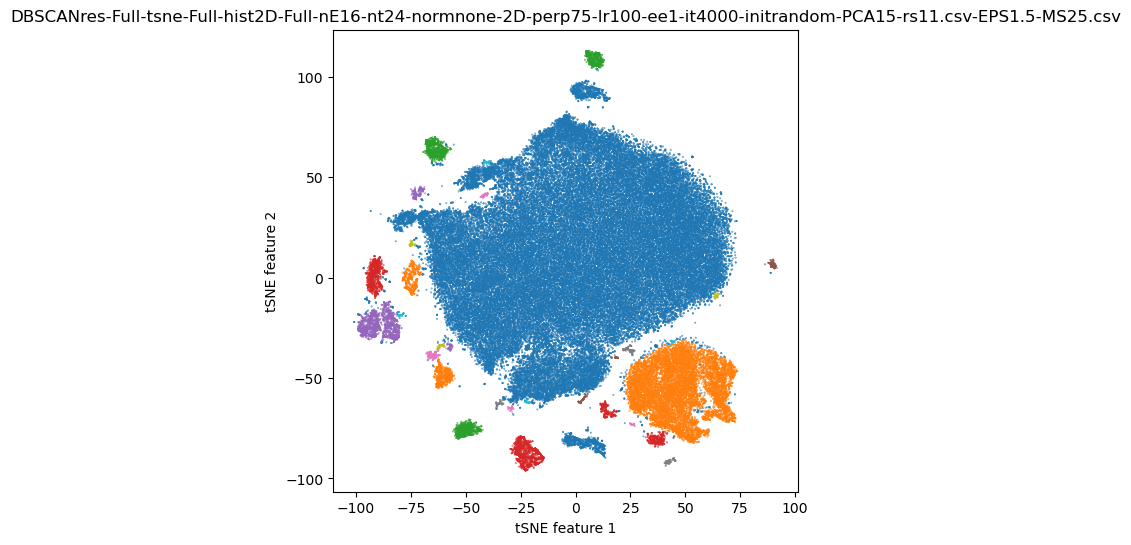

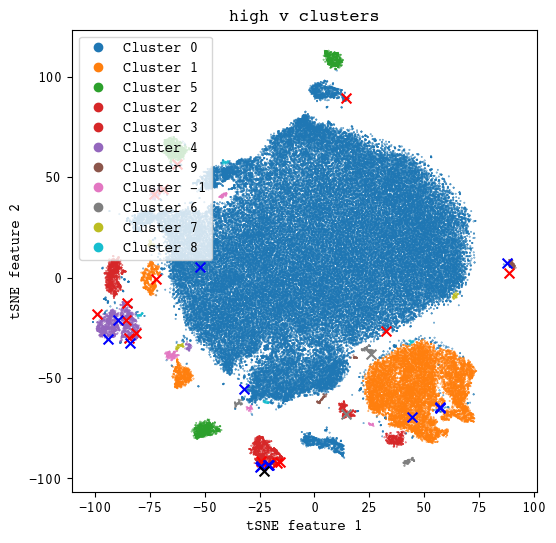

In [14]:
# PLOT
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
cluster = axs.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], cmap = 'tab10', s=0.1)
axs.set_xlabel('tSNE feature 1')
axs.set_ylabel('tSNE feature 2')
axs.set_title(f'high v clusters')
unique_clusters = df_tsne_filter['cluster'].unique()
legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]

fig, axs2 = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
cluster = axs2.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], cmap = 'tab10', s=0.1)
axs2.set_xlabel('tSNE feature 1')
axs2.set_ylabel('tSNE feature 2')
axs2.set_title(f'high v clusters')
unique_clusters = df_tsne_filter['cluster'].unique()
legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]
axs2.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c='red', marker='x', s=50, label='Flares')
axs2.scatter(tsne_dips['tsne1'], tsne_dips['tsne2'], c='blue', marker='x', s=50, label='Dips')
axs2.scatter(tsne_rosanne['tsne1'], tsne_rosanne['tsne2'], c='black', marker='x', s=50, label='Rosanne')
axs2.scatter(tsne_lin_irwin['tsne1'], tsne_lin_irwin['tsne2'], c='grey', marker='x', s=50, label='Others')
axs2.legend(cluster.legend_elements()[0], legend_labels)
axs.set_title(dbscan_file)


plt.show()


In [ ]:
# # Run HDBSCAN
# min_cluster_size = 50
# min_samples = 5
# clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
# cluster_labels = clusterer.fit_predict(tsne12)
# n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
# n_noise = list(cluster_labels).count(-1)
# df_tsne_filter['cluster'] = cluster_labels
# silhouette_avg = silhouette_score(tsne12, cluster_labels)
# print(f"Silhouette Score: {silhouette_avg}")
# print(f"Number of clusters: {n_clusters}")
# print(f"Number of noise points: {n_noise}")

# Run KMeans
k_values = range(2, 30)

# # Try each value of K and calculate the silhouette score
# best_score = -1
# best_k = None
# for k in k_values:
#     kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, random_state=42)
#     kmeans.fit(tsne12)
#     score = silhouette_score(tsne12, kmeans.labels_)
#     if score > best_score:
#         best_score = score
#         best_k = k

# Use the best value of K to cluster the data
# best_k = 500
# kmeans = KMeans(n_clusters=best_k, init='k-means++', max_iter=100, random_state=42)
# cluster_labels = kmeans.fit_predict(tsne12)
# df_tsne_filter['cluster'] = cluster_labels
# n_clusters = len(set(cluster_labels))
# n_noise = list(cluster_labels).count(-1)
# print(f"Number of clusters: {n_clusters}")
# print(f"Number of noise points: {n_noise}")



# from sklearn.cluster import DBSCAN
# from sklearn.metrics import pairwise_distances
# from sklearn.metrics import silhouette_score
# import numpy as np
# import matplotlib.pyplot as plt

# # Compute the distance matrix for your dataset
# D = pairwise_distances(X, metric='euclidean')

# # Range of eps and min_samples values to try
# eps_range = np.arange(0.1, 1.0, 0.1)
# min_samples_range = range(5, 15)

# # Compute the silhouette score for each combination of eps and min_samples
# silhouette_scores = np.zeros((len(eps_range), len(min_samples_range)))
# for i, eps in enumerate(eps_range):
#     for j, min_samples in enumerate(min_samples_range):
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(X)
#         if len(set(labels)) > 1:
#             silhouette_scores[i,j] = silhouette_score(X, labels)

# # Plot the silhouette scores as a heatmap
# plt.imshow(silhouette_scores, cmap='hot', interpolation='nearest', origin='lower')
# plt.xlabel('min_samples')
# plt.xticks(range(len(min_samples_range)), min_samples_range)
# plt.ylabel('eps')
# plt.yticks(range(len(eps_range)), eps_range)
# plt.colorbar()
# plt.show()

# # Find the combination of eps and min_samples with the highest silhouette score
# i, j = np.unravel_index(np.argmax(silhouette_scores), silhouette_scores.shape)
# eps = eps_range[i]
# min_samples = min_samples_range[j]
# print("Optimal eps:", eps)
# print("Optimal min_samples:", min_samples)